In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split    
import os
import re
import string, emoji
from wordsegment import segment
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.model_selection import StratifiedKFold

In [25]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to C:\Users\VINOTH KUMAR
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\VINOTH KUMAR
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\VINOTH KUMAR
[nltk_data]     M\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\VINOTH KUMAR M\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [26]:
headers = ['tweet', 'label']

df = pd.read_csv('dataset.csv')
df.to_csv("./data.csv", index=False)
df.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


In [ ]:
def _pos_tag_to_wordnet(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

In [ ]:
from wordsegment import load, segment
import re

load()

def replace_hashtag(text):
    def _split_hash(match):
        h = match.group(0)[1:]  # remove '#'
        h_clean = re.sub(r'[^a-zA-Z]', '', h)  # keep only letters
        if not h_clean:
            return ""
        try:
            pieces = segment(h_clean)
            return " ".join(pieces) if pieces else h_clean
        except ValueError:
            # If segmentation fails, just return original cleaned hashtag
            return h_clean
    return re.sub(r'#\w+', _split_hash, text)

In [29]:

def preprocess_text_improved(text, remove_stopwords=True, lemmatize=True):
    """
    Returns a cleaned string.
    - replace URLs, mentions
    - demojize emojis (emoji -> :smile:)
    - expand hashtags into words
    - normalize repeated characters
    - replace numbers with <NUM>
    - remove punctuation (keeps internal apostrophes removed)
    - lower, tokenize, optional stopword removal and lemmatize
    """
    if not isinstance(text, str):
        return ""
    # 1. lower
    text = text.lower()

    # 2. urls and mentions
    text = re.sub(r'http\S+|www\.\S+', ' ', text)          # remove URLs
    text = re.sub(r'@\w+', ' ', text)                     # remove @mentions

    # 3. demojize (turn emoji into textual token like :smile:)
    text = emoji.demojize(text, delimiters=(" ", " "))    # "🙂" -> " :slightly_smiling_face: "
    
    # 4. hashtags -> split into words
    text = replace_hashtag(text)

    # 5. replace digits with <NUM>
    text = re.sub(r'\d+(?:[\.,]\d+)*', ' <NUM> ', text)

    # 6. normalize elongated characters: reduce 3+ repeats to 2 (so looove -> loove)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # 7. remove punctuation (keep spaces). If you want to keep emoticon punctuation, adjust.
    # Remove punctuation except the placeholder tokens like :smile: and <NUM>
    # First preserve coloned tokens (e.g. :smile:) by temporary marker
    text = re.sub(r':([a-z0-9_+-]+):', r' EMOJI_\1_EMO ', text)
    text = text.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    text = re.sub(r'\s+', ' ', text).strip()
    # restore emoji tokens
    text = re.sub(r'EMOJI_([a-z0-9_+-]+)_EMO', r':\1:', text)

    if text == "":
        return ""

    # 8. tokenize
    tokens = word_tokenize(text)

    # 9. optional stopword removal, but keep <NUM> and emoji tokens
    stop_words = set(stopwords.words('english'))
    if remove_stopwords:
        filtered = []
        for t in tokens:
            if t == '<NUM>' or (t.startswith(':') and t.endswith(':')):
                filtered.append(t)
            elif t not in stop_words:
                filtered.append(t)
        tokens = filtered

    # 10. lemmatize with POS
    lemmatizer = WordNetLemmatizer()
    if lemmatize:
        pos_tags = pos_tag(tokens)
        lem_tokens = []
        for tok, tag in pos_tags:
            wn_tag = _pos_tag_to_wordnet(tag)
            tok_lem = lemmatizer.lemmatize(tok, wn_tag)
            lem_tokens.append(tok_lem)
        tokens = lem_tokens

    # 11. final join
    cleaned = " ".join(tokens)
    return cleaned

In [30]:
def preprocess_dataframe(df, text_column='tweet', label_column='label'):
    """
    Adds 'clean_text' column (or overwrite) and drops rows with empty cleaned text.
    Returns cleaned dataframe and (optionally) label encoder if needed.
    """
    df = df.copy()
    df[text_column] = df[text_column].apply(preprocess_text_improved)
    # drop rows where cleaned text is empty
    before = len(df)
    df = df[df[text_column].str.strip().astype(bool)].reset_index(drop=True)
    after = len(df)
    print(f"Preprocessing: dropped {before-after} empty rows (out of {before}).")
    return df

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    precision_score, recall_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize


def evaluate_model(y_true, y_pred, y_score=None):
    """
    Evaluate model performance with metrics and visualizations.
    
    y_true: true labels
    y_pred: predicted labels
    y_score: predicted probabilities (required for ROC curves)
    """
    
    # ======== PRINT METRICS ========
    print("\nPerformance on test data:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred, average="weighted"))
    print('Recall:', recall_score(y_true, y_pred, average="weighted"))
    
    # ======== CONFUSION MATRIX HEATMAP ========
    cm = confusion_matrix(y_true, y_pred)
    classes = np.unique(y_true)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap')
    plt.show()
    
    # ======== ROC CURVE ========
    if y_score is not None:
        plt.figure(figsize=(6, 4))
        
        if len(classes) == 2:
            # Binary ROC
            fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
        
        else:
            # Multi-class ROC (One-vs-Rest)
            y_true_bin = label_binarize(y_true, classes=classes)
            for i in range(len(classes)):
                fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()


In [32]:
from sklearn.neighbors import KNeighborsClassifier
def train_knn(X_train, X_test, y_train, y_test):
    knn = KNeighborsClassifier()
    param_grid = {
        "n_neighbors" : [3, 5, 7, 9, 11],
        "weights" : ["uniform", "distance"],
        "metric" : ["euclidean", "manhattan"]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_knn = grid_search.best_estimator_

    y_pred = best_knn.predict(X_test)

    print("\nK-Nearest Neighbors")
    print("Best Parameters: ", grid_search.best_params_)

    evaluate_model(y_test, y_pred)
    return best_knn

In [33]:
from sklearn.linear_model import LogisticRegression
def train_logistic_regression(X_train, X_test, y_train, y_test):
    lr = LogisticRegression(max_iter=1000)
    param_grid = {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(lr, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_lr = grid_search.best_estimator_
    y_pred = best_lr.predict(X_test)
    print("\nLogistic Regression:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)

    evaluate_model(y_test, y_pred)
    return best_lr

In [34]:
from sklearn.svm import LinearSVC
def train_svm(X_train, X_test, y_train, y_test):
    svm = LinearSVC()
    param_grid = {
        "C" : [0.001, 0.01, 0.1, 1, 10]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    print("\nLogistic Regression:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)

    evaluate_model(y_test, y_pred)
    return best_model

In [35]:
from sklearn.tree import DecisionTreeClassifier

def train_decision_tree(X_train, X_test, y_train, y_test):
    tree = DecisionTreeClassifier()
    param_grid = {
        "max_depth" : [5, 10, 20]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(tree, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    print("\nLogistic Regression:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)

    evaluate_model(y_test, y_pred)
    return best_model

In [36]:
from sklearn.ensemble import VotingClassifier

def train_ensemble(model1, model2, model3, model4, X_train, X_test, y_train, y_test):
    ensemble = VotingClassifier(
        estimators=[
        ('dt', model1),
        ('rf', model2),
        ('lr', model3),
        ('svc', model4)
    ]
    )
    param_grid = {
        "voting" : ["soft", "hard"],
        "weights": [[1, 1, 1, 1], [1, 2, 2, 1]]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(ensemble, param_grid, cv=cv, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print("\nLogistic Regression:")
    print("Best Parameters:", grid_search.best_params_)
    print("Best Validation Score:", grid_search.best_score_)

    return evaluate_model(y_test, y_pred)
    

In [37]:
X = df['tweet']
y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1, random_state=42)
tfidf_vectorizer =  TfidfVectorizer(
    ngram_range=(1, 2),       # unigrams, bigrams, trigrams
    min_df=5,                 # ignore words in <3 documents
    max_df=0.7,               # ignore words in >80% of documents
    sublinear_tf=True,        # logarithmic term frequency scaling
    max_features=2000,       # limit features to top 20k by term frequency
    norm='l2'                 # L2 normalization (good for linear models)
)
train_tfidf = tfidf_vectorizer.fit(df['tweet'])

In [48]:
import pickle

le = LabelEncoder()
y_encoded = le.fit(Y_train)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [39]:
dir = './split'
os.makedirs(dir, exist_ok=True)
train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)
test_df = preprocess_dataframe(test_df)
test_df.to_csv('./split/test.csv', index=False)
train_df = preprocess_dataframe(train_df)
train_df.to_csv('./split/train.csv')
train_df_encoded = tfidf_vectorizer.transform(train_df['tweet'])
train_df_encoded = pd.DataFrame(train_df_encoded.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
train_df_encoded.to_csv('./split/train_df_encoded.csv', index=False)
print(train_df['label'].value_counts())

Preprocessing: dropped 0 empty rows (out of 1060).
Preprocessing: dropped 0 empty rows (out of 9540).
label
real    5002
fake    4538
Name: count, dtype: int64


In [40]:
size = train_df.shape[0] // 5
dir = './tfidf'
dir1 = './preprocess'
os.makedirs(dir, exist_ok=True)
os.makedirs(dir1, exist_ok=True)
# Shuffle the dataset once
shuffled_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into 4 equal parts (last split may have 1 extra row if not divisible)
splits = np.array_split(shuffled_df, 4)

for i, split_df in enumerate(splits, start=1):
    # Save raw text
    split_df.to_csv(f'./split/train_{i}.csv', index=False)
    
    # Transform to TF-IDF
    tfidf_matrix = tfidf_vectorizer.transform(split_df['tweet'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
                            columns=tfidf_vectorizer.get_feature_names_out())
    
    tfidf_df.to_csv(f'./tfidf/train_{i}.csv', index=False)

test_df = pd.read_csv('./split/test.csv')
test_df = tfidf_vectorizer.transform(test_df['tweet'])
test_df = pd.DataFrame(test_df.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
test_df.to_csv('./tfidf/test.csv', index=False)

C:\Users\VINOTH KUMAR M\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [41]:
X_test = pd.read_csv('./tfidf/test.csv')
y_test = pd.read_csv('./split/test.csv')
y_test = y_test['label']

C:\Users\VINOTH KUMAR M\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



K-Nearest Neighbors
Best Parameters:  {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}

Performance on test data:
Confusion Matrix:
[[480  37]
 [150 393]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.76      0.93      0.84       517
        real       0.91      0.72      0.81       543

    accuracy                           0.82      1060
   macro avg       0.84      0.83      0.82      1060
weighted avg       0.84      0.82      0.82      1060

Accuracy:  0.8235849056603773
Precision: 0.839793873670574
Recall: 0.8235849056603773


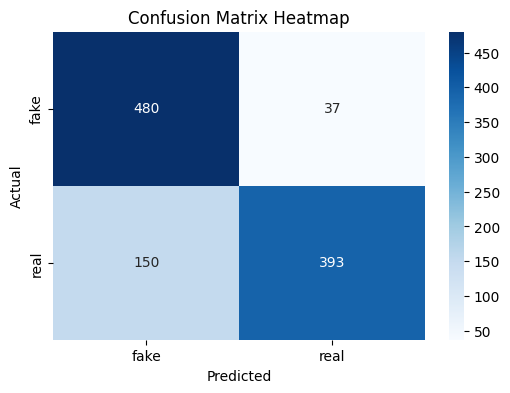

In [47]:
X_train = pd.read_csv("./tfidf/train_1.csv")
y_train = pd.read_csv('./split/train_1.csv')
y_train = y_train['label']

y_train_encoded = y_encoded.transform(y_train)
model1 = train_knn(X_train, X_test, y_train, y_test)


Logistic Regression:
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Validation Score: 0.8935010482180294

Performance on test data:
Confusion Matrix:
[[443  74]
 [ 66 477]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.86      0.86       517
        real       0.87      0.88      0.87       543

    accuracy                           0.87      1060
   macro avg       0.87      0.87      0.87      1060
weighted avg       0.87      0.87      0.87      1060

Accuracy:  0.8679245283018868
Precision: 0.8679595113858838
Recall: 0.8679245283018868


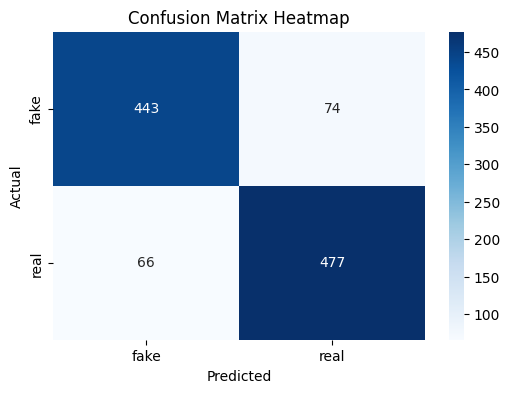

In [43]:
X_train = pd.read_csv("./tfidf/train_2.csv")
y_train = pd.read_csv('./split/train_2.csv')
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
model2 = train_logistic_regression(X_train, X_test, y_train, y_test)


Logistic Regression:
Best Parameters: {'C': 0.1}
Best Validation Score: 0.879245283018868

Performance on test data:
Confusion Matrix:
[[450  67]
 [ 59 484]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.88      0.87      0.88       517
        real       0.88      0.89      0.88       543

    accuracy                           0.88      1060
   macro avg       0.88      0.88      0.88      1060
weighted avg       0.88      0.88      0.88      1060

Accuracy:  0.8811320754716981
Precision: 0.8811749701146914
Recall: 0.8811320754716981


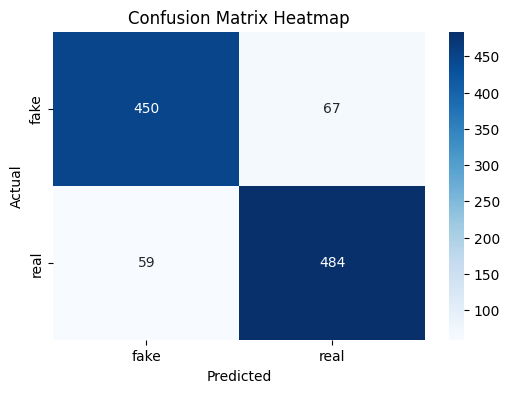

In [44]:
X_train = pd.read_csv("./tfidf/train_3.csv")
y_train = pd.read_csv('./split/train_3.csv')
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
model3 = train_svm(X_train, X_test, y_train, y_test)


Logistic Regression:
Best Parameters: {'max_depth': 20}
Best Validation Score: 0.8293501048218029

Performance on test data:
Confusion Matrix:
[[441  76]
 [127 416]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.78      0.85      0.81       517
        real       0.85      0.77      0.80       543

    accuracy                           0.81      1060
   macro avg       0.81      0.81      0.81      1060
weighted avg       0.81      0.81      0.81      1060

Accuracy:  0.8084905660377358
Precision: 0.8118161511637705
Recall: 0.8084905660377358


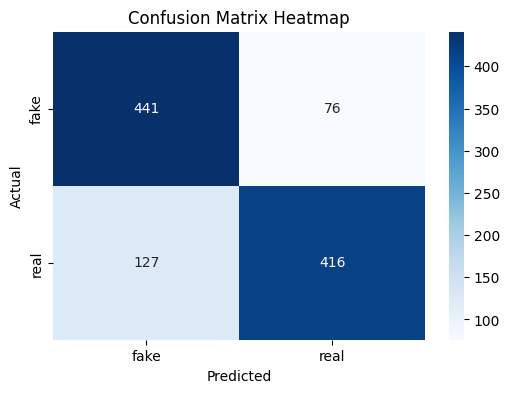

In [45]:
X_train = pd.read_csv("./tfidf/train_4.csv")
y_train = pd.read_csv('./split/train_4.csv')
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
model4 = train_decision_tree(X_train, X_test, y_train, y_test)

C:\Users\VINOTH KUMAR M\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.90377358 0.90890985]
  warnings.warn(



Logistic Regression:
Best Parameters: {'voting': 'hard', 'weights': [1, 2, 2, 1]}
Best Validation Score: 0.9089098532494759

Performance on test data:
Confusion Matrix:
[[477  40]
 [ 57 486]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.89      0.92      0.91       517
        real       0.92      0.90      0.91       543

    accuracy                           0.91      1060
   macro avg       0.91      0.91      0.91      1060
weighted avg       0.91      0.91      0.91      1060

Accuracy:  0.9084905660377358
Precision: 0.9089828595058244
Recall: 0.9084905660377358


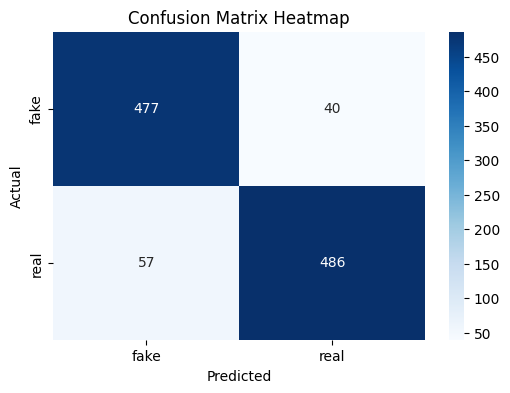

In [46]:
X_train = pd.read_csv("./split/train_df_encoded.csv")
y_train = pd.read_csv("./split/train.csv")
y_train = y_train['label']
y_train_encoded = y_encoded.transform(y_train)
train_ensemble(model1, model2, model3, model4, X_train, X_test, y_train, y_test)